In [1]:
# Data processing
# ==============================================================================
import warnings
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.ForecasterRnn import ForecasterRnn
import skforecast
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow
import plotly.offline as poff
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Plotting
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
set_dark_theme()
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Tensorflow and Keras
# ==============================================================================

# Time series modeling
# ==============================================================================

# Warning configuration
# ==============================================================================
warnings.filterwarnings('once')

print(f"skforecast version: {skforecast.__version__}")
print(f"tensorflow version: {tensorflow.__version__}")

c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


skforecast version: 0.12.1
tensorflow version: 2.10.1


In [2]:
# Downloading the dataset and processing it
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia")

air_quality_valencia
--------------------
Hourly measures of several air quimical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26304, 10)


In [3]:
# Missing values imputation
# ==============================================================================
air_quality = air_quality.interpolate(method="linear")
air_quality = air_quality.sort_index()
air_quality.head()

,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0


In [4]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {air_quality.index.dtype}")
print(f"Frequency: {air_quality.index.freq}")

Index: datetime64[ns]
Frequency: <Hour>


In [5]:
# Split train-validation-test
# ==============================================================================
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Dates train      : {air_quality_train.index.min()} --- "
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Dates validation : {air_quality_val.index.min()} --- "
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Dates test       : {air_quality_test.index.min()} --- "
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Dates train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Dates validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Dates test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



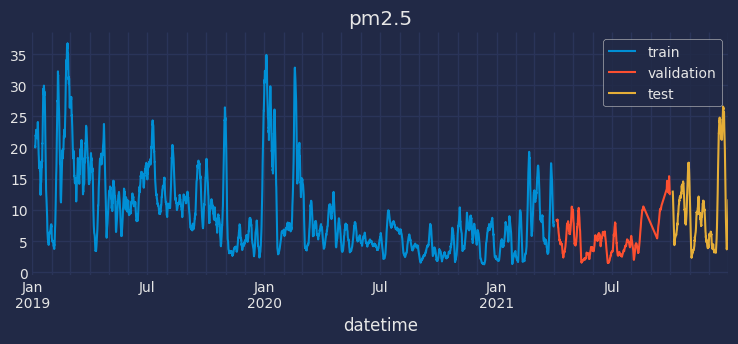

In [6]:
# Plotting pm2.5
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend()

In [7]:
# Create model
# ==============================================================================
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target serie to predict
lags = 32  # Past time steps to be used to predict the target
steps = 1  # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


C:\Users\yylee\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning:

non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version



In [8]:


# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)

forecaster

c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:222: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:252: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



AttributeError: 'Functional' object has no attribute 'get_compile_config'

In [9]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
615/615 [==============================] - 6s 8ms/step - loss: 0.0085 - val_loss: 0.0057
Epoch 2/10
615/615 [==============================] - 5s 8ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 3/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 4/10
425/615 [===================>..........] - ETA: 1s - loss: 0.0054

KeyboardInterrupt: 

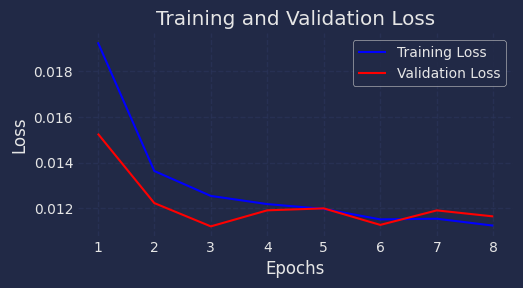

In [ ]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)

In [ ]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,42.668549
2021-04-01 01:00:00,40.867973
2021-04-01 02:00:00,38.100906
2021-04-01 03:00:00,36.141186
2021-04-01 04:00:00,35.948830


In [ ]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    # Training + Validation Data
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,  # Set to True for detailed information
    refit=False,
)

tensorflow INFO  Assets written to: ram://969a1344-0fb7-4ef3-bf8c-e252c3ec2640/assets
C:\Users\yylee\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning:

non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version



FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://4d74ece4-75e5-4083-9f47-d0329b5be603/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
# Backtesting predictions
# ==============================================================================
predictions

In [ ]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index,
                    y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index,
                    y=predictions['o3'], name="predictions", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
fig.show()

In [ ]:
# Backtesting metrics
# ==============================================================================
metrics

In [ ]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")